# Use `if` condition


## Introduction

This tutorial provides a step-by-step guide on how to implement conditional logic in WorkGraph using two distinct methods:

1. **If Task**
2. **graph_builder Decorator**


## Using the If Task

In the WorkGraph user interface, the `If Task` is visually represented as an "If Zone." This zone encapsulates all its child tasks, which are executed based on the defined conditions.

- **Conditions**: The If Zone includes a `conditions` socket, which determines when the tasks inside the zone should be executed.
- **Invert_condition**: If this input is True, it will invert the conditions.
- **Task Linking**: Tasks located outside the If Zone can be directly linked to tasks within the zone, allowing for dynamic workflow adjustments based on conditional outcomes.


### Example

Suppose we want to calculate the following workflow, the tasks for each step are shown:

In [1]:
from aiida.engine import  calcfunction
from aiida import load_profile

load_profile()

@calcfunction
def add(x, y):
    return x + y

@calcfunction
def multiply(x, y):
    return x*y

@calcfunction
def compare(x, y):
    return x<y

# ---------------------------------------------------------
# start the workflow
# step 1
result = add(1, 1)
# step 2
if compare(result, 0):
    result = add(result, 2)           # use add task
else:
    result = multiply(result, 2)      # use multiply task
# step 3
result = add(result, 1)
# ---------------------------------------------------------
print("Result is", result)

Result is uuid: 14ba8e7f-4ae7-4f5c-ac23-8165aa45a9e8 (pk: 107076) value: 5


### Create the workflow
Now, let'use create the workflow using the `While` task.

In [2]:
from aiida_workgraph import task, WorkGraph

@task()
def select(condition, x, y):
    """Output the result based on the condition."""
    if condition:
        return x
    return y

wg = WorkGraph("if_task")
add1 = wg.add_task(add, name="add1", x=1, y=1)
condition1 = wg.add_task(compare, name="condition1", x=1, y=0)
add2 = wg.add_task(add, name="add2", x=add1.outputs["result"], y=2)
if1 = wg.add_task("If", name="if_true",
                        conditions=condition1.outputs["result"])
if1.children.append("add2")
multiply1 = wg.add_task(multiply, name="multiply1", x=add1.outputs["result"], y=2)
if2 = wg.add_task("If", name="if_false",
                        conditions=condition1.outputs["result"],
                        invert_condition=True)
if2.children.append("multiply1")
#---------------------------------------------------------------------
select1 = wg.add_task(select, name="select1", x=add2.outputs["result"],
                      y=multiply1.outputs["result"],
                      condition = condition1.outputs["result"])
add3 = wg.add_task(add, name="add3", x=select1.outputs["result"], y=1)
wg.to_html()
# wg.run()
# wg.save()
# wg

In the GUI, **If** task is shown as a **If Zone** with all its child tasks inside the Zone. 
The if zone have `conditions` socket. Tasks outside the while zone can link to the tasks inside the zone directly.

### Submit the WorkGraph and check the results


In [3]:
wg.submit(wait=True)
print("State of WorkGraph:   {}".format(wg.state))
print('Result of add1   :   {}'.format(add3.outputs["result"].value))

WorkGraph process created, PK: 107077
State of WorkGraph:   FINISHED
Result of add1   :   uuid: b4103125-e0be-48ed-b304-3ae2e80ff971 (pk: 107091) value: 5


Generate node graph from the AiiDA process,and we can see that when `compare1` node outputs `False`, the workgraph stops.

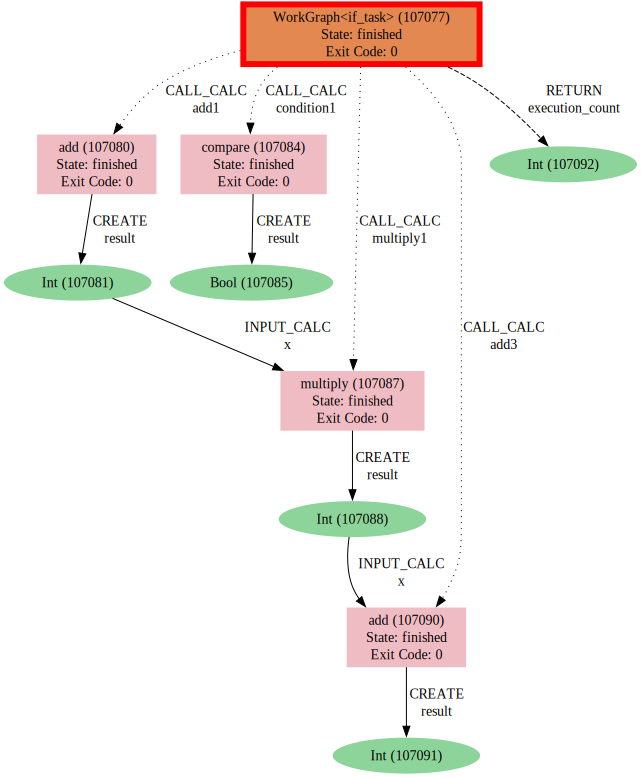

In [4]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

## Using the graph_builder Decorator

The `graph_builder` decorator is used for creating a dynamic `WorkGraph` during runtime based on input values. This method differs significantly from the `If Task`:

- **Visibility**: In the GUI, only the `graph_builder` task is visible before execution.
- **Dynamic Generation**: Upon running, it generates the WorkGraph dynamically, allowing for complex conditional logic and flow adjustments based on runtime data.



In [5]:
# Create a WorkGraph which is dynamically generated based on the input
# then we output the result of from the context (context)
@task.graph_builder(outputs = [{"name": "result", "from": "context.result"}])
def add_multiply_if(x, y):
    wg = WorkGraph()
    if x.value > 0:
        add1 = wg.add_task(add, name="add1", x=x, y=y)
        # export the result of add1 to the context
        add1.set_context({"result": "result"})
    else:
        multiply1 = wg.add_task(multiply, name="multiply1", x=x, y=y)
        # export the result of multiply1 to the context
        multiply1.set_context({"result": "result"})
    return wg

### Create the workflow


In [6]:
from aiida_workgraph import WorkGraph

wg = WorkGraph("if_graph_builer")
add1 = wg.add_task(add, name="add1", x=1, y=1)
add_multiply_if1 = wg.add_task(add_multiply_if, name="add_multiply_if1", x=add1.outputs["result"], y=2)
add1 = wg.add_task(add, name="add2", x=add_multiply_if1.outputs["result"], y=1)
wg.to_html()
# wg

In the GUI, we only see the `add_multiply_if1` task. When this task run, it will generate a `WorkGraph` based on the input value. This is different from the `If` task, in which we see all tasks before the WorkGraph run.


### Submit the WorkGraph and check the results


In [7]:
wg.submit(wait=True)
print("State of WorkGraph         : {}".format(wg.state))
print('Result of add1            : {}'.format(wg.tasks["add2"].outputs["result"].value))

WorkGraph process created, PK: 107093
State of WorkGraph         : FINISHED
Result of add1            : uuid: f4c9c0bc-1121-4388-a7f9-52dc31866654 (pk: 107105) value: 5


Generate node graph from the AiiDA process,and we can see that the `multiply` task is executed.

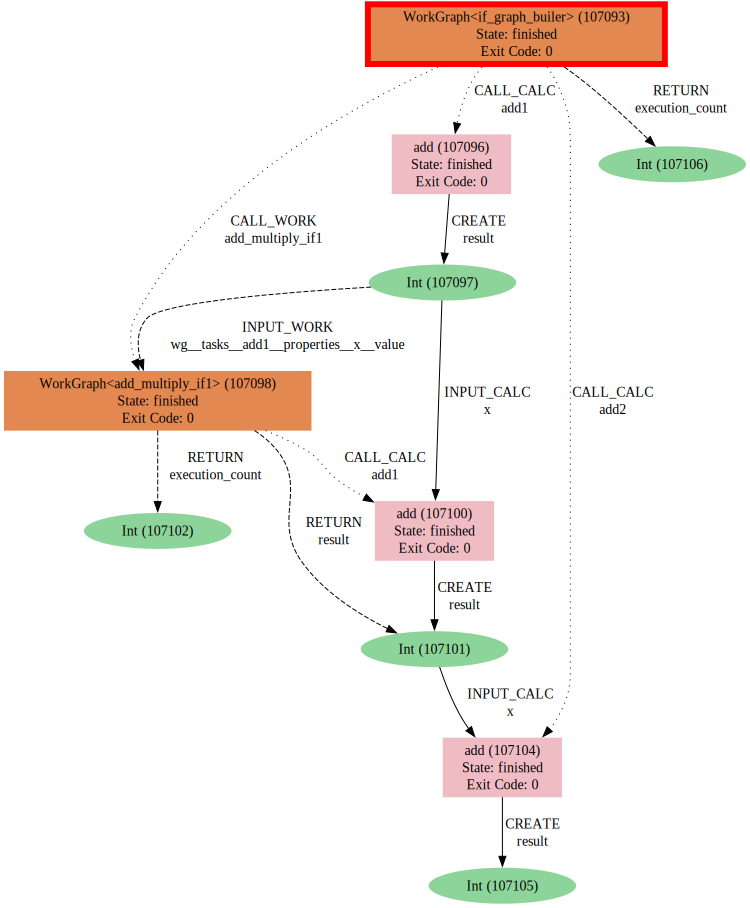

In [8]:
from aiida_workgraph.utils import generate_node_graph
generate_node_graph(wg.pk)

### Summary

The `If Task` provides a visual and structured approach to managing conditional tasks within a defined zone. In contrast, the `graph_builder` decorator offers flexibility by dynamically generating the workflow based on runtime inputs, suitable for complex and adaptive process flows.
